# Modeling Phase – Baseline & Classical Models

In this notebook, we:

- Implement naive and moving average baseline forecasts to establish reference performance.
- Build and evaluate ARIMA/SARIMA models on the target energy consumption time series.
- Perform feature engineering to improve the model performance.
- Use grid search to find the best model parameters for the ARIMA and SARIMAX models.
- Compare results using standard metrics (MAE, RMSE, MAPE, R²).
- Use the model coefficients to identify the most relevant features for the forecast.

# Libraries

In [1]:
# System & Data Handling
# import os
# import shutil
import pickle

# Data Loading
# import kagglehub
import pandas as pd

# Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
# import calendar

# Time Series Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import ParameterGrid

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Constants
FIGSIZE = (16, 5)
FIGSIZE_LONG=(20, 6)

# Loading cleaned data
Loading the cleaned data from EDA phase

In [2]:
with open('../data/data_cleaned.pkl', 'rb') as f:
    data_cleaned = pickle.load(f)

df_data = data_cleaned['df_data']
df_data = df_data.drop(columns=['DayOfWeek','RollingMean']).rename(columns = {'DayOfWeek_ext':'DayOfWeek'})
df_data.head()


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Date,Time,DayOfWeek
Timestamp,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,Off,Off,14.391800,No,75.913906,2022-01-04,0,Tuesday
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,On,Off,25.875969,Yes,84.191467,2022-01-04,1,Tuesday
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,On,Off,17.471965,Yes,75.251764,2022-01-04,2,Tuesday
2022-01-04 03:00:00,22.140257,49.424878,1037.206885,7,Off,On,3.329908,Yes,75.014471,2022-01-04,3,Tuesday
2022-01-04 04:00:00,24.175776,41.800150,1198.625224,6,Off,Off,18.470624,No,69.365745,2022-01-04,4,Tuesday


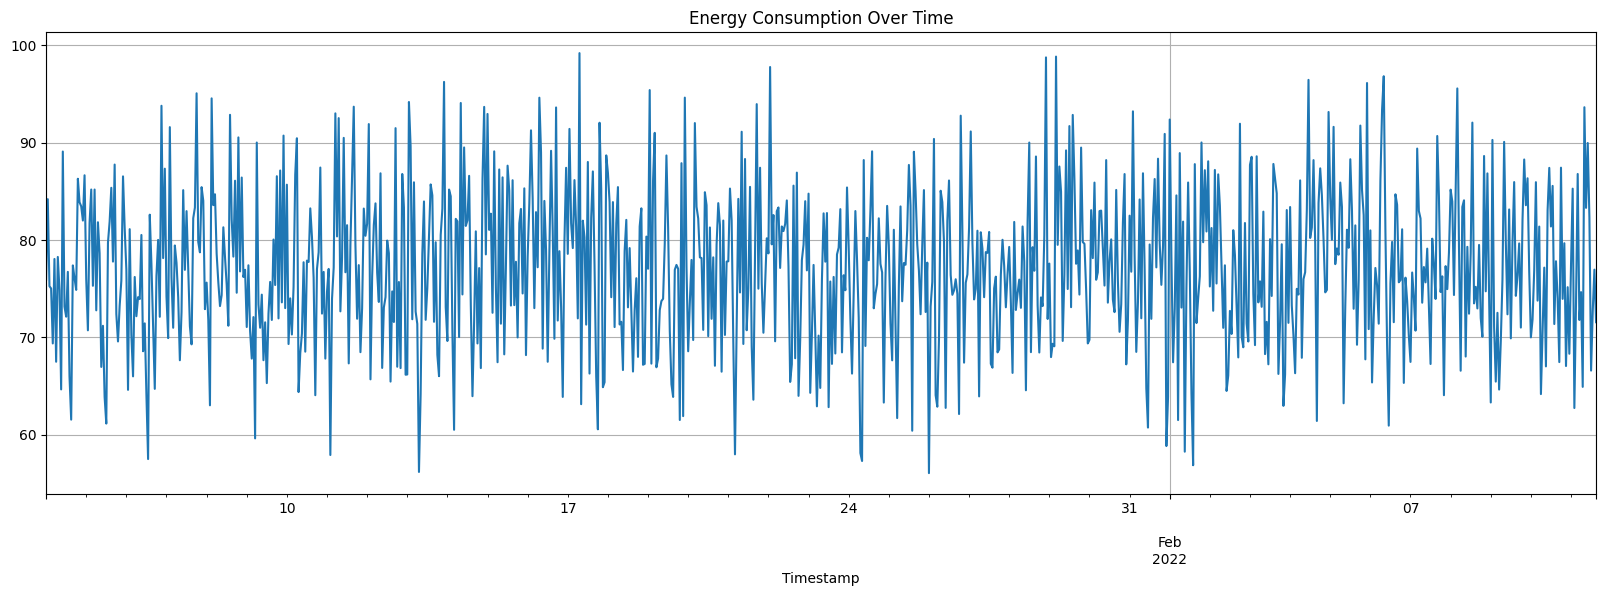

In [3]:
df_data['EnergyConsumption'].plot(title="Energy Consumption Over Time", figsize=FIGSIZE_LONG)
plt.grid(True)
plt.show()

# Test/ Train data split
- We preserve the last 24 hours of data as the test set and use the rest as the training set
- The training set is also used for cross-validation and grid search to choose the best model parameters


In [4]:
# import numpy as np

forecast_horizon = 24
target_col = 'EnergyConsumption'
train_hr = df_data.iloc[:-forecast_horizon][target_col].asfreq('h')
test_hr = df_data.iloc[-forecast_horizon:][target_col].asfreq('h')

forecast_horizon = 7
df_data_24h_complete = data_cleaned['df_data_24h_complete']
df_daily = df_data_24h_complete['EnergyConsumption'].resample('D').sum()
df_daily = df_daily.to_frame()
train_day = df_daily.iloc[:-forecast_horizon][target_col].asfreq('D')
test_day = df_daily.iloc[-forecast_horizon:][target_col].asfreq('D')

# Utility functions:
- Evaluation of prediction using the metrics, MAE, RMSE, MAPE, and R2
- Cross-validation of the model
- Grid search for the best model parameters
- Visualizaiton of the training, test, and prediction samples

## Evaluate and visualize 
Evalutaing the performance of a single model on test data and visualizing its forcast values

In [5]:

def evaluate_model(df_predictions, verbose=True):
    y_pred = df_predictions['prediction'].values
    y_true = df_predictions['truth'].values

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)

    if verbose:
        print("Rolling-Window Forecast Evaluation:")
        print(f"MAE:  {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R2:   {r2:.4f}")

    results = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

    return results

def visualize_prediction(df_predictions, df_data, title, last_n_samples=48):
    # Visualize the prediction
    df_viz = df_data.iloc[-last_n_samples:].copy()
    plt.figure(figsize=(12, 5))
    plt.plot(df_viz.index, df_viz['EnergyConsumption'],  label="Training Data",    marker='o')
    plt.plot(df_predictions.index, df_predictions['truth'],  label="Test Data",    marker='o')
    plt.plot(df_predictions.index, df_predictions['prediction'],  label="Forecast",  marker='x', linestyle='--')
    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Cross validation - evaluating models performance

In [6]:
class cv_splitter:
    def __init__(self, n_splits: int, test_size: int):
        """
        n_splits:   how many test windows you want
        test_size:  number of samples in each test window
        """
        self.backward_jump = 10
        self.n_splits  = n_splits
        self.test_size = test_size

    def split(self, y):
        """
        y: array-like or pandas Series of length N
        yields: (train_idx, test_idx) pairs
        """
        n_samples = len(y)
        for i in range(self.n_splits):
            test_end   = n_samples - i * self.backward_jump
            test_start = test_end - self.test_size
            if test_start <= 0:
                break  # not enough data for further splits
            train_idx = np.arange(0, test_start)
            test_idx  = np.arange(test_start, test_end)
            yield train_idx, test_idx

# Cross validation with 5 folds and prediction horizon of 24            
tscv = cv_splitter(n_splits = 5, test_size = 24)            

### cross validation function

In [43]:
def cross_validation_generic(y,
                             exog=None,
                             cv=None,
                             forecast_fn=None,
                             verbose=True,
                             **model_kwargs):
    """
    """
    # prepare metrics collection
    metrics_per_fold = {m: [] for m in ['mae','rmse','mape','r2']}
    
    # iterate folds
    for fold, (train_idx, test_idx) in enumerate(cv.split(y), start=1):
        if verbose:
            print(f"=== Fold {fold} ===")
            print(f" Train: {train_idx[0]} … {train_idx[-1]}")
            print(f"  Test: {test_idx[0]} … {test_idx[-1]}")
        
        y_train, y_test           = y.iloc[train_idx], y.iloc[test_idx]
        exog_train = exog.iloc[train_idx] if exog is not None else None
        exog_test  = exog.iloc[test_idx]  if exog is not None else None
        
        # call the generic forecasting function
        if exog is not None:
            df_pred = forecast_fn(y_train, y_test,
                                  exog_train=exog_train,
                                  exog_test=exog_test,
                                  **model_kwargs)
        else:
            # print(model_kwargs)
            # return None
            df_pred = forecast_fn(y_train, y_test, **model_kwargs)
        if type(df_pred)==tuple:
            # print(df_pred)
            df_pred = df_pred[0]
        # return df_pred
        # evaluate
        res = evaluate_model(df_pred, verbose=False)
        if verbose:
            print(f" Fold {fold} → RMSE: {res['rmse']:.3f}, MAPE: {res['mape']:.2f}%")
        
        # collect
        for m in metrics_per_fold:
            metrics_per_fold[m].append(res[m])
    
    # average folds
    avg_metrics = {m: np.mean(vals) for m, vals in metrics_per_fold.items()}
    if verbose:
        print("\nAverage CV metrics:")
        print(f"  MAE:  {avg_metrics['mae']:.3f}")
        print(f"  RMSE: {avg_metrics['rmse']:.3f}")
        print(f"  MAPE: {avg_metrics['mape']:.2f}%")
        print(f"  R²:   {avg_metrics['r2']:.4f}")
    
    return avg_metrics

# df_predictions =cross_validation_generic(train_hr, cv = tscv, forecast_fn = rolling_window_forecast, window_size=24)
# print(avg_metrics)
# df_predictions

params = {'order':(0,0,0)}
# avg_metrics =cross_validation_generic(train_hr, cv = tscv, forecast_fn = arima_model, verbose=False, **params)

# params = {'window_size':24}
# avg_metrics =cross_validation_generic(train_hr, cv = tscv, forecast_fn = rolling_window_forecast, verbose=False, **params)

params = {'order':(0,0,0), 'seasonal_order':(0,0,0,24)}
# avg_metrics =cross_validation_generic(train_hr, exog = exog_train, cv = tscv, forecast_fn = sarimax_model, verbose=False, **params)

# print(avg_metrics)
# avg_metrics = avg_metrics[0]
# avg_metrics


## Grid search function

In [ ]:
def grid_search_generic(train, forecast_fn, 
                        param_grid,
                        exog=None,
                        metric = 'mae',                          
                        verbose = True):
    # collect (window_size, mape) for each trial
    results = []
    total_combo = len(ParameterGrid(param_grid))
    for params in ParameterGrid(param_grid):
        # if window_size > len(train):
        #     print(f"Window size {window_size} is greater than the training data length {len(train)}")
        #     continue

        # df_pred, metrics = rolling_window_forecast(train, test, window_size)
        metrics =cross_validation_generic(train, cv = tscv, 
                                          exog = exog, forecast_fn = forecast_fn, 
                                          verbose = verbose, **params)
        results.append((params, metrics[metric]))
        print(f', {len(results)}/{total_combo}', end='')

    # unpack into two lists if you still want to plot
    # print(results)
    # return None
    param_dicts, scores = zip(*results)
    # print(param_dicts)
    # print(scores)

    if len(param_grid) == 1:
        param_name = list(param_grid.keys())[0]
        # print(param_name)
        param_vals = [p[param_name] for p in param_dicts]
        # print(param_vals)
        labels = [str(x) for x in param_vals]
        # print(labels)
    else:        
        labels = [f"{p['order']}/{p['seasonal_order']}" for p in param_dicts]
        # print(labels)

    # plot the MAPE for each window size
    plt.figure(figsize=(16, 3))
    plt.plot(labels, scores, marker='o')
    plt.xlabel("Parameters")
    plt.xticks(rotation=90, ha='right')
    plt.ylabel(metric.upper())
    plt.title(f"Grid Search — {metric.upper()} for Each Window Size")
    plt.grid(True)
    plt.show()

    # find the (window_size, mape) tuple with smallest mape
    *best_params, best_error = min(results, key=lambda x: x[-1])
    print(f"The best parameters are {best_params} with a {metric} of {best_error:.2f}")

    return best_params, best_error, results


param_grid= {'window_size': range(1,48)}
window_size_best, min_mape, all_mape = grid_search_generic(train_hr, rolling_window_forecast, param_grid = param_grid, verbose= False)

param_grid = {
    'order': [(p,0,q) for p in range(2) for q in range(2)]
    # 'seasonal_order': [(p,d,q) for p in range(3) for q in range(3) for d in range(3)]
}
# best_params, min_mape, all_mape = grid_search_generic(train_hr, arima_model, param_grid = param_grid, verbose= False)

param_grid = {
    'order': [(p,0,q) for p in [1] for q in range(2)],
    'seasonal_order': [(p,0,q,24) for p in [1] for q in range(2)]
}
# exog=exog_train
# best_params, min_mape, all_mape = grid_search_generic(train_hr, sarimax_model, exog = exog_train, param_grid = param_grid, verbose= False)

# best_params


NameError: name 'rolling_window_forecast' is not defined

Rolling-Window Forecast Evaluation:
MAE:  7.118
RMSE: 73.955
MAPE: 9.37%
R2:   -0.1003


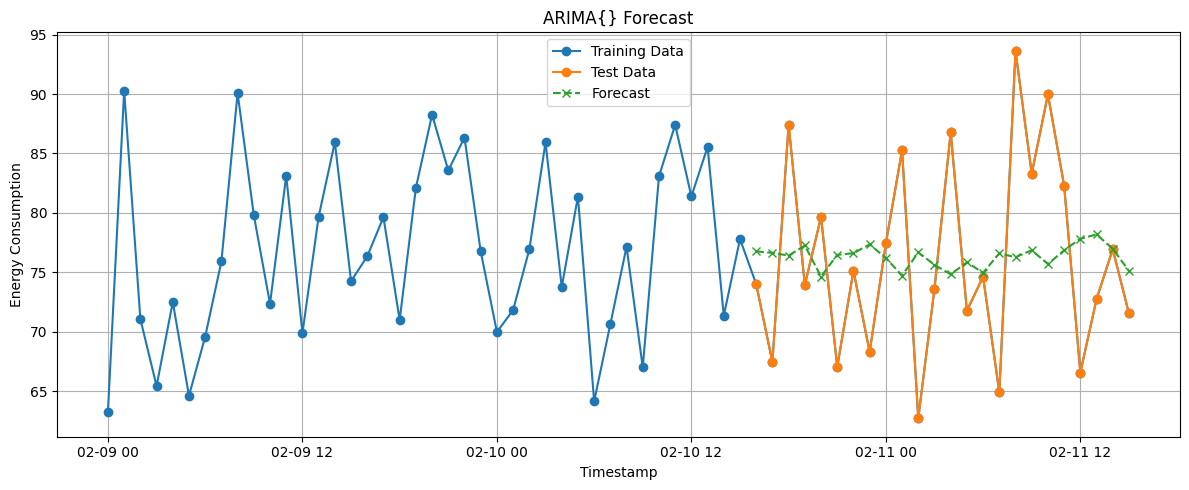

In [42]:
order = (8, 0, 6)
df_predictions_arima = arima_model(train_hr, test_hr, order)
seasonal_order = (1,0,1,24)

df_predictions_sarimax, results = sarimax_model(train_hr, test_hr,
                    order, 
                    seasonal_order,
                    exog_train, 
                    exog_test
                    )
df_predictions = df_predictions_arima
df_predictions = df_predictions_sarimax
result_arima =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_data, title="ARIMA{} Forecast", last_n_samples=64)

# Baseline model - moving average
We use the moving average model and a rolling windows on the past samples to predict the next sample of the data

## Forecast function

In [17]:
# Rolling window of data for each 24 samples

def rolling_window_forecast(train, test, window_size, verbose=False):
    # window_size = window_size{'window_size'}
    
    if verbose:
        print(window_size, len(train), len(test))
    # return None

    df_predictions = pd.DataFrame(index=test.index, columns=['prediction', 'truth'])
    df_predictions['truth'] = test.values

    history = train.iloc[-window_size:].tolist()

    for ts in df_predictions.index:
        next_pred = np.mean(history[-window_size:])
        df_predictions.loc[ts, 'prediction'] = next_pred
        history.append(next_pred)
    
    # results = evaluate_model(df_predictions, verbose=verbose)
    
    return df_predictions

## Grid search and forecast performance

, 1/47, 2/47, 3/47, 4/47, 5/47, 6/47, 7/47, 8/47, 9/47, 10/47, 11/47, 12/47, 13/47, 14/47, 15/47, 16/47, 17/47, 18/47, 19/47, 20/47, 21/47, 22/47, 23/47, 24/47, 25/47, 26/47, 27/47, 28/47, 29/47, 30/47, 31/47, 32/47, 33/47, 34/47, 35/47, 36/47, 37/47, 38/47, 39/47, 40/47, 41/47, 42/47, 43/47, 44/47, 45/47, 46/47, 47/47

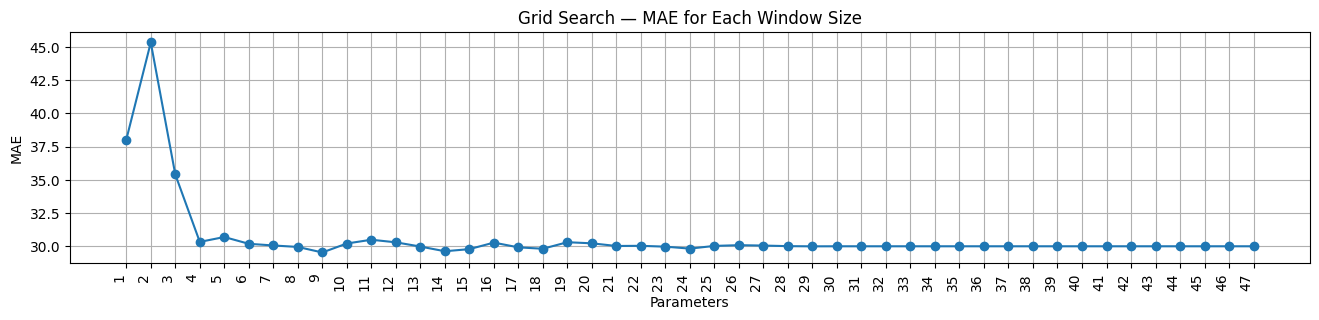

The best parameters are [{'window_size': 9}] with a mae of 29.52
Rolling-Window Forecast Evaluation:
MAE:  7.497
RMSE: 74.703
MAPE: 10.17%
R2:   -0.1114


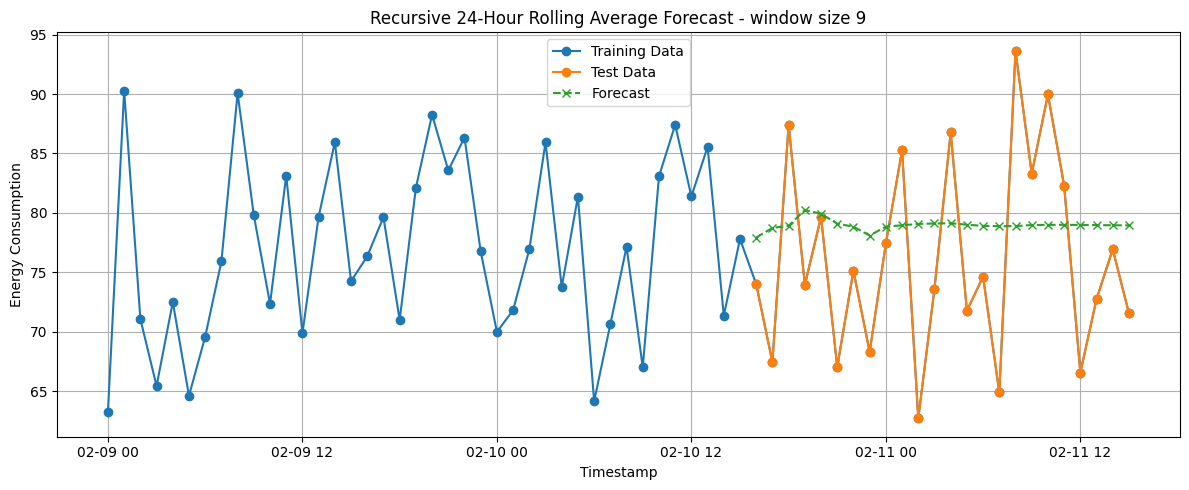

In [ ]:
param_grid= {'window_size': range(1,48)}
best_params, min_mape, all_mape = grid_search_generic(train_day, rolling_window_forecast, param_grid = param_grid, verbose= False)
window_size_best = best_params[0]['window_size']

# prediction with the best forecast horizon
df_predictions_baseline = rolling_window_forecast(train_hr, test_hr, window_size_best, verbose=False)
results_baseline = evaluate_model(df_predictions_baseline, verbose=True)

# Visualize the prediction
title = f"Recursive 24-Hour Rolling Average Forecast - window size {window_size_best}"
visualize_prediction(df_predictions_baseline, df_data, title, last_n_samples=64)


# ARIMA model
The arima model has the parameters (p, d, q), refereing to the AR (AutoRegressive), differencing, and MA (Moving Average) parts of the model.

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt
from itertools import product

def arima_model(train, test, order):
    # print(len(train), len(test), order)
    ''' This function fits an ARIMA model to the training data and returns a dataframe of the predictions and the true values.
    Args:
        train: pd.Series, the training data
        test: pd.Series, the test data
        order: tuple, the order of the ARIMA model (p,d,q)
    Returns:
        df_predictions: pd.DataFrame, the predictions and the true values
    '''
    # Fit ARIMA with selected order
    model = ARIMA(train, order=order)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", 
            message=".*divide by zero encountered.*|.*overflow encountered.*|.*invalid value encountered.*|.*Using zeros.*|.*Maximum Likelihood optimization*.")
        model_fit = model.fit()
    
    
    forecast_horizon = len(test)
    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Wrap into dataframe for evaluation
    df_predictions = pd.DataFrame(index=test.index)
    df_predictions['prediction'] = forecast.values 
    df_predictions['truth'] = test.values

    return df_predictions

def extract_best_params(all_results, labels, errors, figsize=FIGSIZE_LONG, metric = 'mape'):
        plt.figure(figsize=figsize)
        plt.plot(labels, errors, marker='o')
        plt.xticks(rotation=90, ha='right')
        plt.xlabel("ARIMA(p,d,q) order")
        plt.ylabel(f"{metric}")
        plt.title(f"ARIMA Grid Search — {metric} by Order")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        # pick the best
        *best_order, best_mape = min(all_results, key=lambda x: x[-1])
        return best_order, best_mape

def grid_search_arima(train, test,
                      p_range=range(0, 10),
                      d_range=range(0, 2),
                      q_range=range(0, 10), figsize=FIGSIZE_LONG, metric = 'mape', verbose=False):
    """
    Grid‐search ARIMA(p,d,q) by evaluating MAPE on the hold‐out `test` set.
    Returns: best_order, best_mape, all_results
      - best_order: tuple (p,d,q)
      - best_mape:   float
      - all_results: list of (order, mape)
    """
    all_results = []
    for p, d, q in product(p_range, d_range, q_range):
        order = (p, d, q)
        if verbose:
            print(f"Fitting ARIMA({order})")
        # fit & forecast
        df_pred = arima_model(train, test, order)        
        m = evaluate_model(df_pred, verbose=False)
        all_results.append((order, m[metric]))

    # unpack for plotting
    orders, errors = zip(*all_results)

    # convert orders to a string for x‐axis labels
    labels = [f"{o[0]},{o[1]},{o[2]}" for o in orders]    
    
    best_order, best_mape = extract_best_params(all_results, labels, errors, figsize, metric)

    print(f"Best ARIMA order: {best_order} → {metric} = {best_mape:.2f}")
    return best_order, best_mape, all_results


## 24 hour forcast
We fit the ARIMA model to the hourly consumption data to forcast its future values

, 1/9, 2/9, 3/9, 4/9, 5/9, 6/9, 7/9, 8/9, 9/9

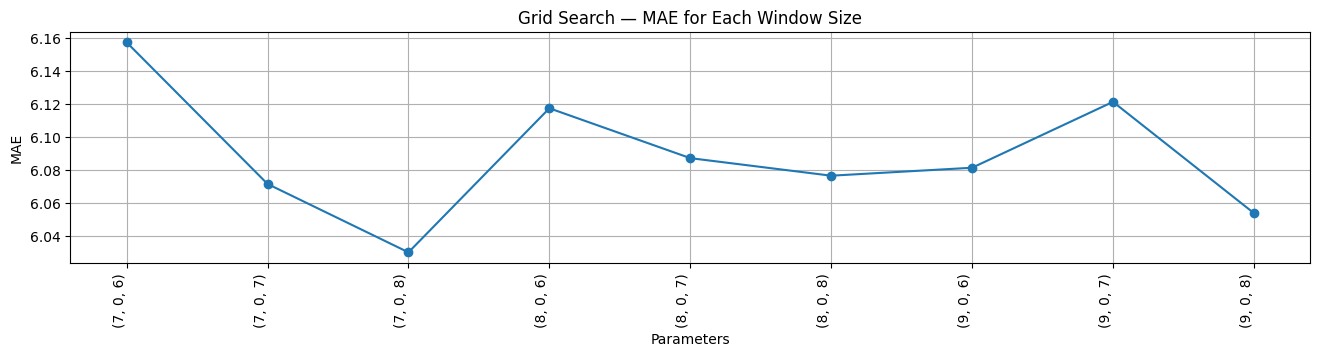

The best parameters are [{'order': (7, 0, 8)}] with a mae of 6.03
Rolling-Window Forecast Evaluation:
MAE:  6.907
RMSE: 67.792
MAPE: 9.22%
R2:   -0.0086


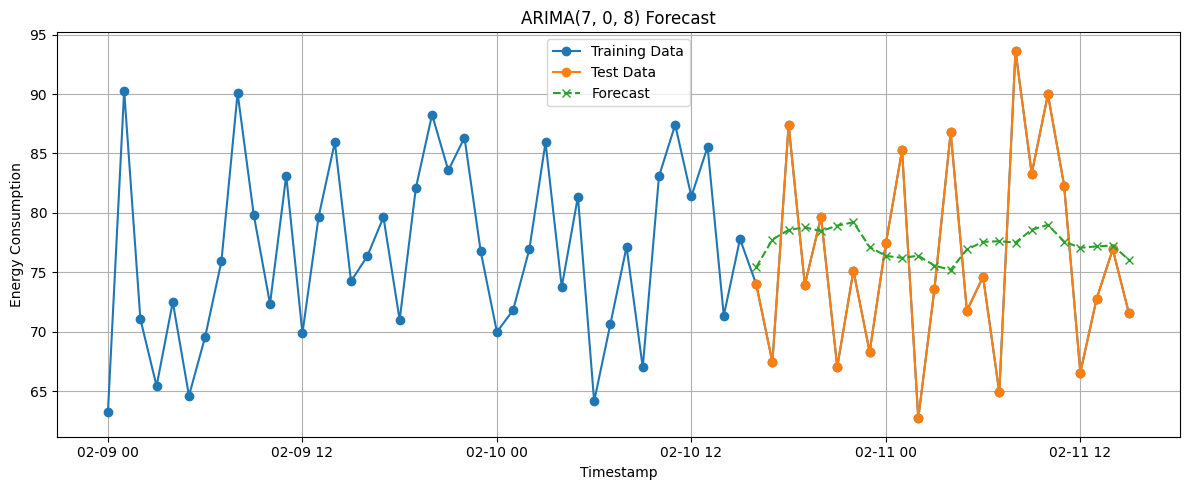

,Baseline_24h,Baseline_Daily,ARIMA_24h
mae,7.497128,32.449498,6.906866
rmse,74.702811,1589.056226,67.791713
mape,10.170028,1.718518,9.218965
r2,-0.111432,-0.295565,-0.008608


In [31]:
# --- USAGE ---
param_grid = {
    # 'order': [(p,0,q) for p in range(10) for q in range(10)]
    'order': [(p,0,q) for p in [7,8,9] for q in [6,7,8]]
}
best_params, min_mape, all_mape = grid_search_generic(
    train_hr, 
    arima_model, 
    param_grid = param_grid, 
    verbose= False)
# best_order, best_mape, results = grid_search_arima(
#     train_hr,
#     test_hr,
#     p_range=range(0,10),
#     d_range=[0],
#     q_range=range(0,10),
#     metric='mae'
# )
best_order = best_params[0]['order']
df_predictions = arima_model(train_hr, test_hr, best_order)
result_arima =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_data, title=f"ARIMA{best_order} Forecast", last_n_samples=64)
df_model_results['ARIMA_24h'] = result_arima
df_model_results


**Observations:**
- We observe that there is not much difference in performance of baseline and the ARIMA model for hourly prediction.
- However ARIMA had a fairly good prediction for daily consumption, especially compared to the baseline


# Feature Engineering for multivariable model
We want to use other features included in the dataset to investigate their impact on forcasting the target variable.
To that aim, we perform features engineering on both categorical and numeric variables.

## Categorical Features' encoding
- Holiday
- DayOfWeek
- HVACUsage
- LightingUsage



In [10]:
cat_cols = df_data.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['Date', 'Time']]
# num_cols = df_data.select_dtypes(include=['int64', 'float64']).columns

print('Categorical Features: ', cat_cols)
# print('\nNumerical Features: ', num_cols)
for col in cat_cols:
    print(f'Unique values in {col}: {df_data[col].unique()}')
# df_data[cat_cols].head()

Categorical Features:  ['HVACUsage', 'LightingUsage', 'Holiday', 'DayOfWeek']
Unique values in HVACUsage: ['Off' 'On']
Unique values in LightingUsage: ['Off' 'On']
Unique values in Holiday: ['No' 'Yes']
Unique values in DayOfWeek: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']


In [11]:
df_features = df_data.copy()
df_features['HVACUsage'] = df_features['HVACUsage'].map({'On': 1, 'Off': 0})
df_features['LightingUsage'] = df_features['LightingUsage'].map({'On':1, 'Off': 0})
df_features['Holiday'] = df_features['Holiday'].map({'Yes':1, 'No': 0})
df_features.head(3)

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Date,Time,DayOfWeek
Timestamp,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,0,0,14.391800,0,75.913906,2022-01-04,0,Tuesday
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,1,0,25.875969,1,84.191467,2022-01-04,1,Tuesday
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,1,0,17.471965,1,75.251764,2022-01-04,2,Tuesday


## Time-based features
- Day of week
- Month
- Hour of the day is already extracted in EDA

In [12]:
df_features['DayOfWeek'] = df_features.index.weekday
df_features['Month'] = df_features.index.month
df_features.head(3)

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Date,Time,DayOfWeek,Month
Timestamp,,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,0,0,14.391800,0,75.913906,2022-01-04,0,1,1
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,1,0,25.875969,1,84.191467,2022-01-04,1,1,1
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,1,0,17.471965,1,75.251764,2022-01-04,2,1,1


## Rolling features

In [13]:
num_cols = df_features.columns.difference(['Date', 'Time','EnergyConsumption'])
print(num_cols)
rol_features = []
for col in num_cols:
    feat = f'{col}_rol'
    df_features[feat] = df_features[col].shift(1).rolling(24).mean()
    # df_features[feat].fillna(method='ffill', inplace=True)  # Fill NaN values with the last valid value
    rol_features.append(feat)

df_features = df_features.ffill().bfill()
df_features[rol_features]

Index(['DayOfWeek', 'HVACUsage', 'Holiday', 'Humidity', 'LightingUsage',
       'Month', 'Occupancy', 'RenewableEnergy', 'SquareFootage',
       'Temperature'],
      dtype='object')


,DayOfWeek_rol,HVACUsage_rol,Holiday_rol,Humidity_rol,LightingUsage_rol,Month_rol,Occupancy_rol,RenewableEnergy_rol,SquareFootage_rol,Temperature_rol
Timestamp,,,,,,,,,,
2022-01-04 00:00:00,1.000000,0.458333,0.583333,44.973538,0.416667,1.0,5.875000,15.829480,1502.538303,24.905928
2022-01-04 01:00:00,1.000000,0.458333,0.583333,44.973538,0.416667,1.0,5.875000,15.829480,1502.538303,24.905928
2022-01-04 02:00:00,1.000000,0.458333,0.583333,44.973538,0.416667,1.0,5.875000,15.829480,1502.538303,24.905928
2022-01-04 03:00:00,1.000000,0.458333,0.583333,44.973538,0.416667,1.0,5.875000,15.829480,1502.538303,24.905928
2022-01-04 04:00:00,1.000000,0.458333,0.583333,44.973538,0.416667,1.0,5.875000,15.829480,1502.538303,24.905928
...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,3.458333,0.333333,0.416667,45.217714,0.500000,2.0,5.208333,16.285160,1464.440489,24.765365
2022-02-11 12:00:00,3.500000,0.333333,0.416667,45.936179,0.500000,2.0,5.125000,16.227052,1432.403594,24.790404
2022-02-11 13:00:00,3.541667,0.333333,0.416667,46.600876,0.541667,2.0,5.166667,17.082403,1438.632242,24.738555


## lag_1 features

In [14]:
num_cols_laged = ['EnergyConsumption','HVACUsage','Humidity', 'LightingUsage', 'Occupancy', 'RenewableEnergy',
                  'SquareFootage', 'Temperature']
lag_features = [f'{feat}_lag' for feat in num_cols_laged]
for feat in num_cols_laged:
    df_features[f'{feat}_lag'] = df_features[feat].shift(1)
print(lag_features)

['EnergyConsumption_lag', 'HVACUsage_lag', 'Humidity_lag', 'LightingUsage_lag', 'Occupancy_lag', 'RenewableEnergy_lag', 'SquareFootage_lag', 'Temperature_lag']


# Cross-Correlation between Output and lagged inputs
- For a forcasting problem we must separate available and unavailable features for each current timestep.
  - For Autoregressive models like ARIMA/SARIMA, we forcast one step ahread of *t*. So, we can consider we have the values of all variables at *t-1*. 
- Compared to the normall correlation matrix from EDA, here we do not observe any strong correlation between Energy consumption value and the first lag of other features. 

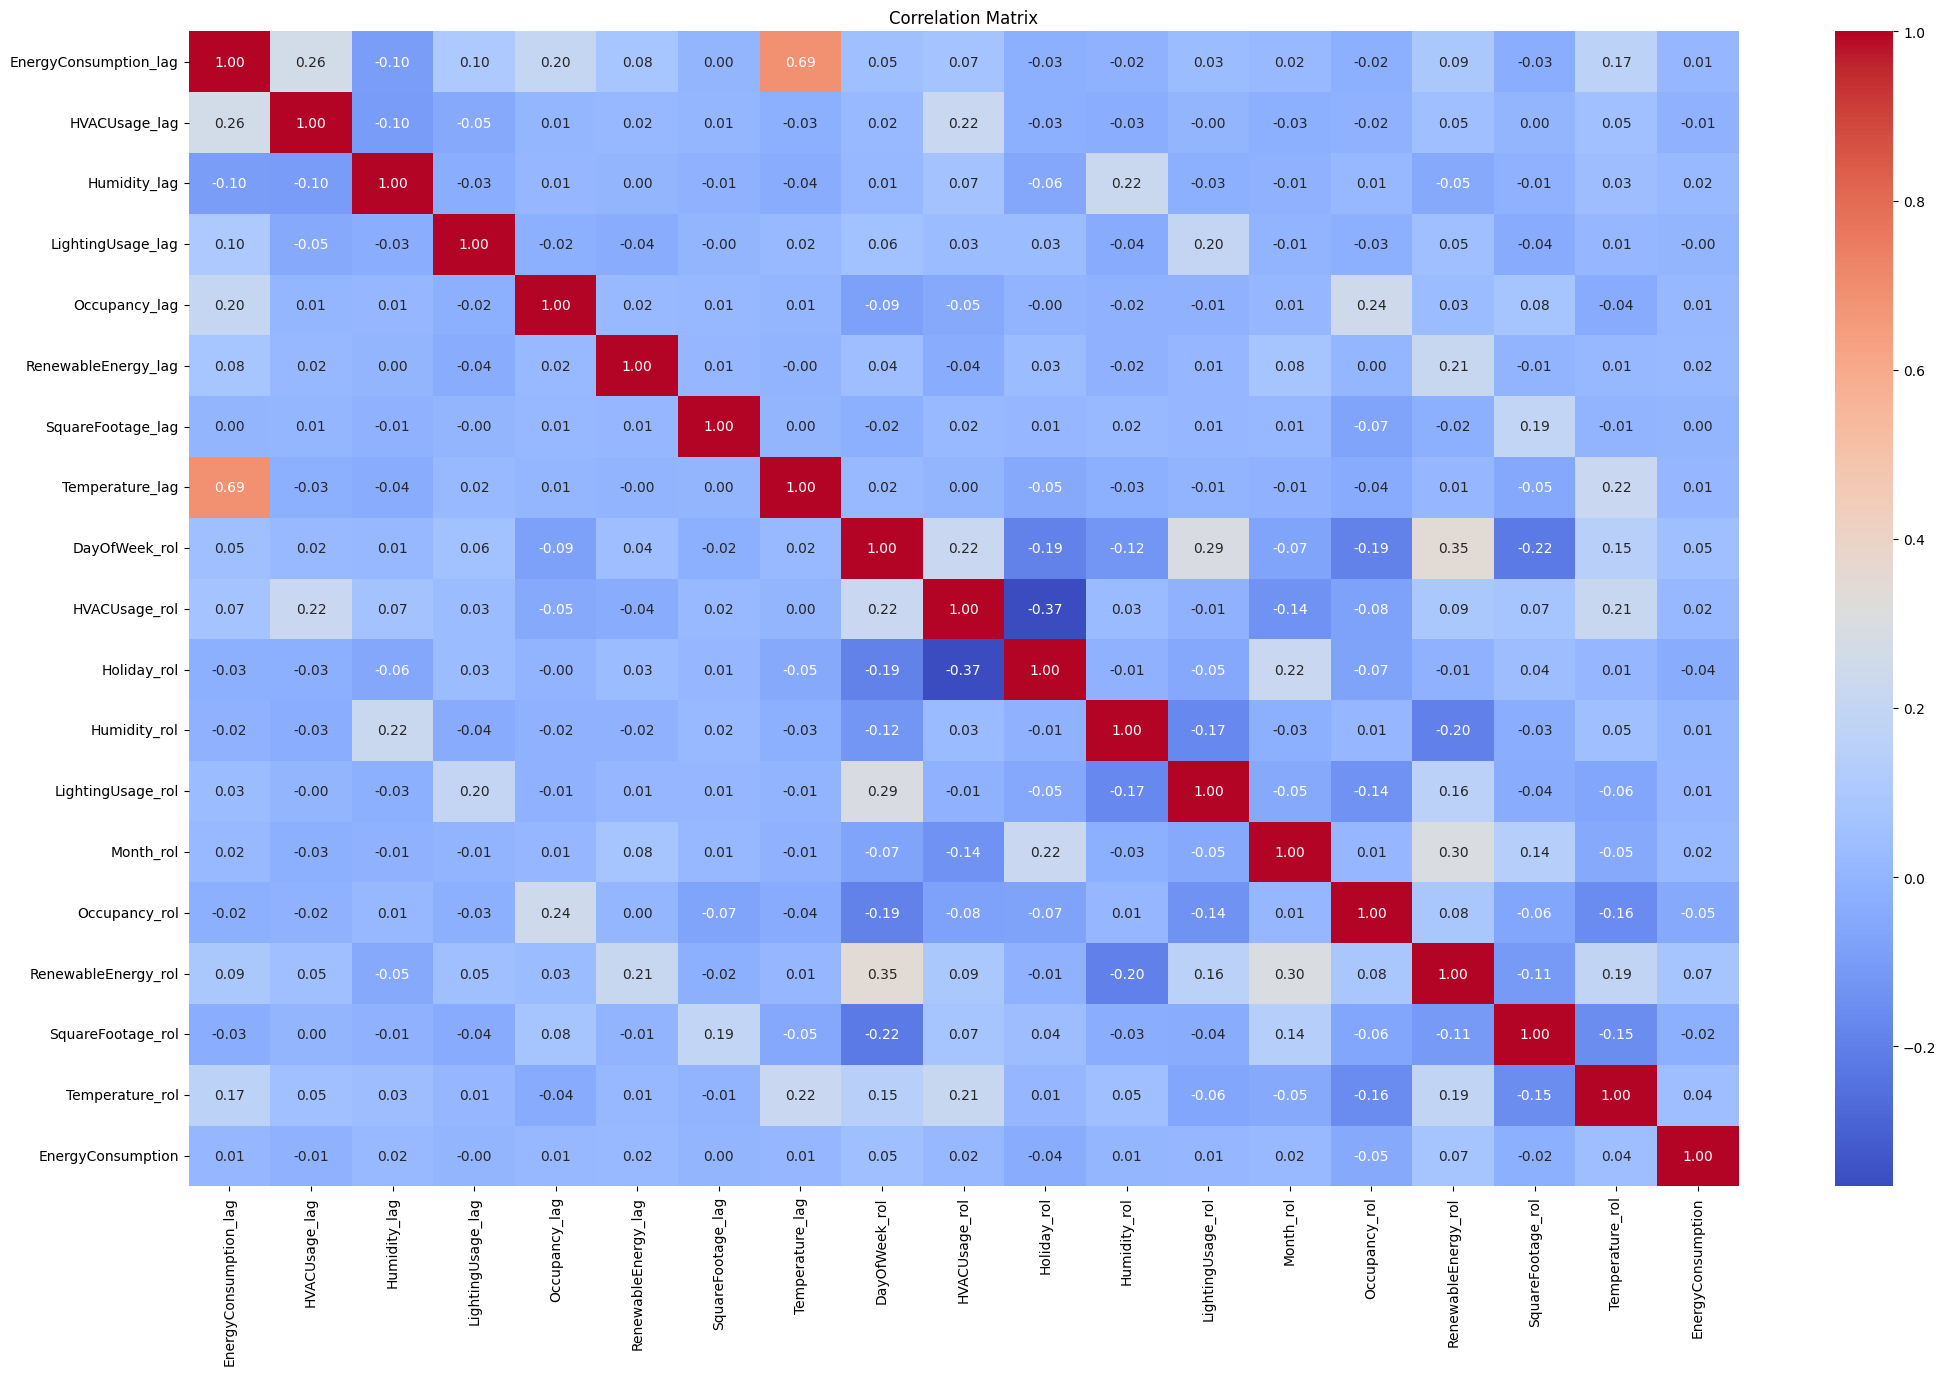

In [15]:

corr_cols = lag_features + rol_features + ['EnergyConsumption']

plt.figure(figsize=(25,15))
correlation_matrix = df_features[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.title('Correlation Matrix')
plt.show()

## Lagged Correlation (Cross-Correlation)
-  We take the above analysis further via cross correlation analysis between the target variable (Energy consumption) and more past steps of input features.

Observation:
- No strong cross correlation between laged features and the output was found.

The cross correlation between Temperature and Energy consumption


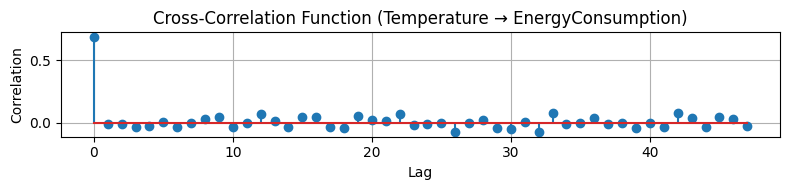

The cross correlation between Humidity and Energy consumption


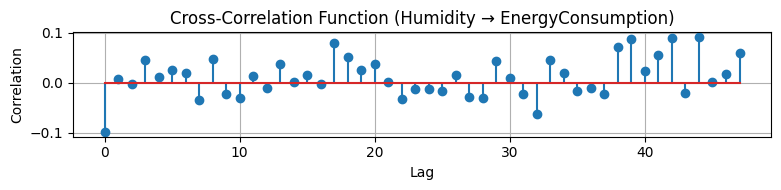

The cross correlation between SquareFootage and Energy consumption


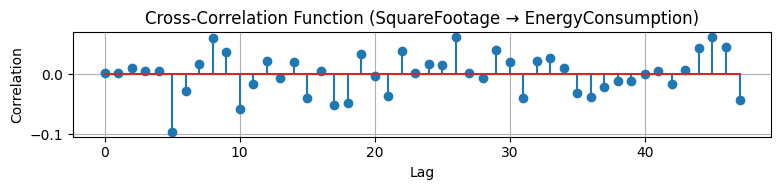

The cross correlation between Occupancy and Energy consumption


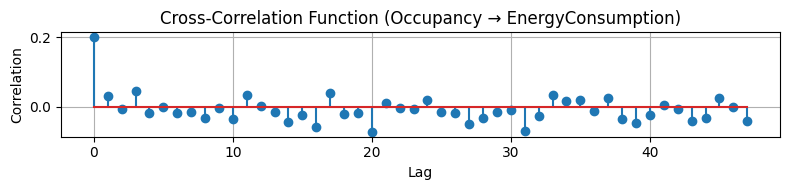

The cross correlation between HVACUsage and Energy consumption


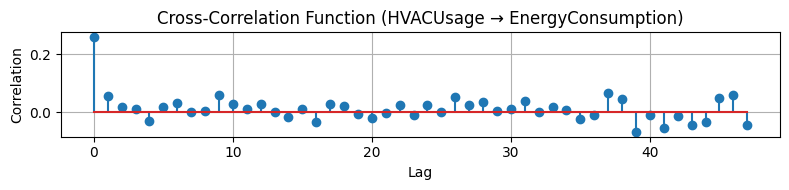

The cross correlation between LightingUsage and Energy consumption


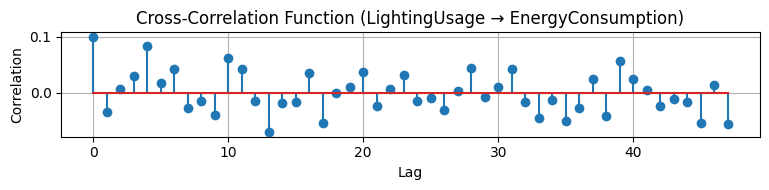

The cross correlation between RenewableEnergy and Energy consumption


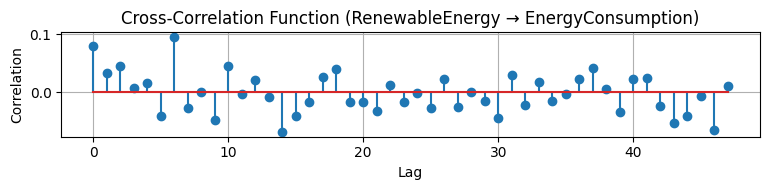

The cross correlation between Holiday and Energy consumption


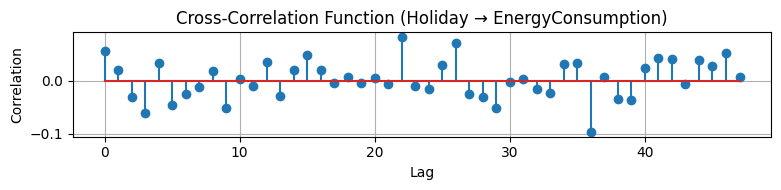

In [16]:
from statsmodels.tsa.stattools import ccf

max_lag = 48
def cross_correlation(df_data, feature_col, max_lag):
    print(f'The cross correlation between {col} and Energy consumption')
    
    # Drop NA and align
    x = df_data[feature_col].dropna()
    y = df_data['EnergyConsumption'].dropna()
    min_len = min(len(x), len(y))
    x = x[-min_len:]
    y = y[-min_len:]

    # Compute cross-correlation
    ccf_vals = ccf(x, y, adjusted=False)
    ccf_vals = ccf_vals[:max_lag]

    # Plot only positive lags
    plt.figure(figsize=(8,2))
    plt.stem(range(len(ccf_vals)), ccf_vals)
    plt.title(f"Cross-Correlation Function ({col} → EnergyConsumption)")
    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# a for loop
input_features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
                'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'Holiday']
for col in input_features:
    cross_correlation(df_features, col, max_lag)


# SARIMAX (SARIMA with exogenous variable)
- order = (p, d, q) → Non-seasonal ARIMA components
- seasonal_order = (P, D, Q, s) → Seasonal ARIMA

## Forcast function

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import matplotlib.pyplot as plt
from itertools import product

def sarimax_model(train, test,
                  order, seasonal_order,
                  exog_train=None, exog_test=None):
    """
    Fit SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order),
    forecast `len(test)` steps (with exog=exog_test), and return predictions df.
    """
    model = SARIMAX(train,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",
            message=".*divide by zero encountered.*|.*overflow encountered.*|.*invalid value encountered.*|.*Using zeros.*|.*Maximum Likelihood optimization*.|.*Too few observations*.")
        res = model.fit(disp=False)

    # Forecast 
    forecast = res.forecast(steps=len(test),
                            exog=exog_test)

    df_pred = pd.DataFrame(index=test.index)
    df_pred['prediction'] = forecast.values
    df_pred['truth']      = test.values
    return df_pred, res


def grid_search_sarimax(train, test,
                        p_range=range(0,3),   
                        d_range=range(0,2),
                        q_range=range(0,3),
                        P_range=range(0,2),
                        D_range=range(0,2),
                        Q_range=range(0,2),
                        s=24,                 # seasonal period
                        exog_train=None,
                        exog_test=None, figsize=FIGSIZE_LONG, metric = 'mape', verbose=False):
    """
    Grid‐search SARIMAX over (p,d,q)x(P,D,Q,s) by evaluating `metric` on the hold‐out test.
    Returns: best_params, best_error, all_results
    """
    all_results = []
    total_combos = len(p_range) * len(d_range) * len(q_range) * len(P_range) * len(D_range) * len(Q_range)
    # total_combs = len(product(p_range, d_range, q_range, P_range, D_range, Q_range))
    best_score = np.inf
    for order in product(p_range, d_range, q_range):
        for seasonal in product(P_range, D_range, Q_range):
            seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)
            if verbose:
                print(f"Trying SARIMAX(order={order}, seasonal={seasonal_order})")            
            try:
                df_pred, _ = sarimax_model(train, test,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    exog_train=exog_train,
                                    exog_test=exog_test)
                errs = evaluate_model(df_pred, verbose=False)
                score = errs[metric]
            except:
                # print(f"Error fitting SARIMAX")
                score = np.inf
            if score < best_score:
                best_score = score
                print(f"\nSARIMAX(order={order}, seasonal={seasonal_order}, {metric}:{score})") 
            all_results.append((order, seasonal_order, score))
            print(f', {len(all_results)} / {total_combos}', end='')

    # return all_results
    # unpack for plotting
    # orders, errors = zip(*all_results)

    # convert orders to a string for x‐axis labels
    labels = [f"{o}/{s}" for o, s, _ in all_results]
    scores = [sc for _, _, sc in all_results]
    
    best_order, best_mape = extract_best_params(all_results, labels, scores, figsize, metric)

    print(f"Best model coefficients: {best_order} → {metric} = {best_mape:.2f}")
    return best_order, best_mape, all_results


## Exogenous features
We add the additional features such as Temperature, Humidity, Occupancy, Time, and Day Of Week to the model as Exogenous features.

In [18]:
forecast_horizon = 24
# ex_cols = df_features.columns.difference(['Date', 'EnergyConsumption'])

lag2_features = []
for col in num_cols_laged:
    feat = f'{col}_lag2'
    df_features[feat] = df_features[col].shift(2)
    lag2_features.append(feat)

ex_cols = lag_features + rol_features + lag2_features

# filling the Nan value of lags and rolling features
df_features = df_features.ffill().bfill()

exog_train = df_features.iloc[:-forecast_horizon][ex_cols].asfreq('h')
exog_test = df_features.iloc[-forecast_horizon:][ex_cols].asfreq('h')

In [ ]:
(best_order, best_seasonal), best_err, grid_results = grid_search_sarimax(
    train_hr, test_hr,
    p_range=range(3), d_range=[0], q_range=range(3),
    P_range=range(2), D_range=[0], Q_range=range(2),
    s=24,
    exog_train = exog_train,
    exog_test = exog_test,
    metric='mae',
    figsize = (20, 10),
    verbose=False
)


SARIMAX(order=(0, 0, 0), seasonal=(0, 0, 0, 24), mae:7.065345607193714)
, 1 / 36, 2 / 36, 3 / 36, 4 / 36, 5 / 36, 6 / 36, 7 / 36, 8 / 36, 9 / 36, 10 / 36, 11 / 36, 12 / 36, 13 / 36, 14 / 36, 15 / 36, 16 / 36, 17 / 36, 18 / 36

Rolling-Window Forecast Evaluation:
MAE:  7.250
RMSE: 76.050
MAPE: 9.53%
R2:   -0.1315


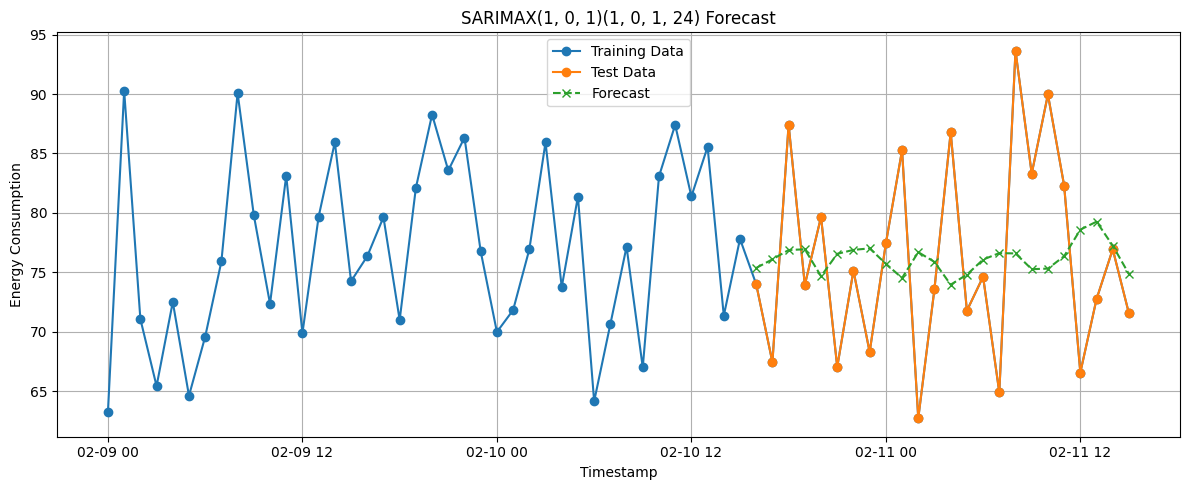

NameError: name 'df_model_results' is not defined

In [94]:
# order = best_order
# seasonal_order = best_seasonal
order = (1,0,1)
seasonal_order = (1,0,1,24)
df_predictions, results = sarimax_model(train_hr, test_hr,
                    order, seasonal_order,
                    exog_train, exog_test)

result_sarimax =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_data, title=f"SARIMAX{order}{seasonal_order} Forecast", last_n_samples=64)
df_model_results['SARIMAX_24h'] = result_sarimax
df_model_results

# Siple daily forcast without CV or grid search
- We cannot perform a proper cross validation due to lack of enough data sample for the daily time series.
  - Except the first training fold, others would have not enough training samples for the models to converge their optimization step

## Baseline - daily prediciton

, 1/13, 2/13, 3/13, 4/13, 5/13, 6/13, 7/13, 8/13, 9/13, 10/13, 11/13, 12/13, 13/13

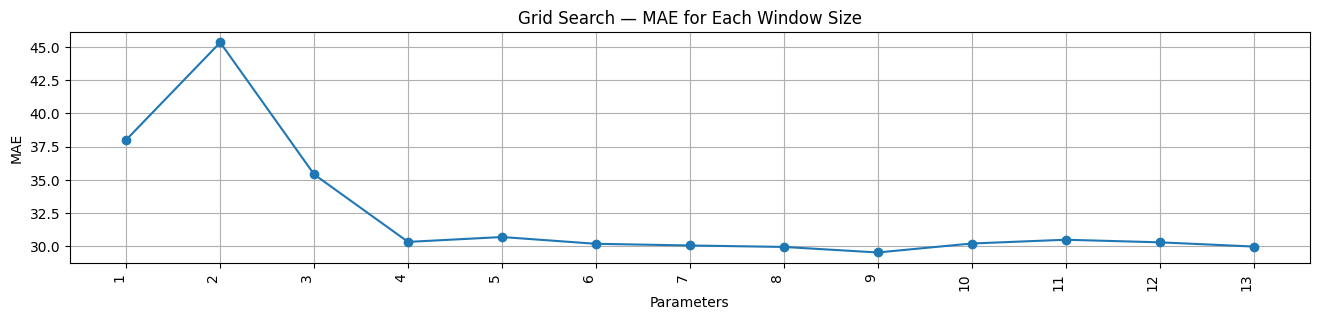

The best parameters are [{'window_size': 9}] with a mae of 29.52
Rolling-Window Forecast Evaluation:
MAE:  32.449
RMSE: 1589.056
MAPE: 1.72%
R2:   -0.2956


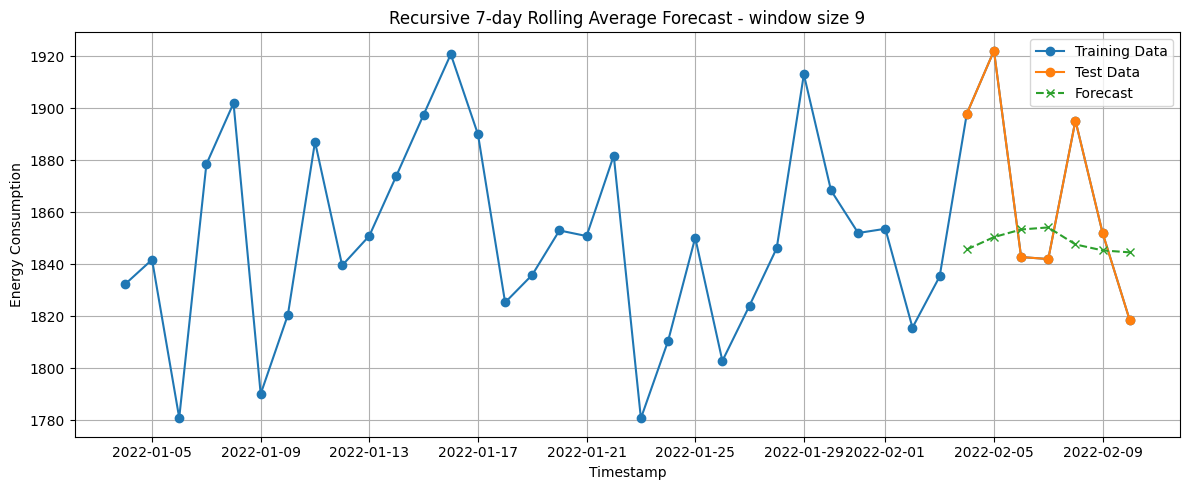

,Baseline_24h,Baseline_Daily
mae,7.497128,32.449498
rmse,74.702811,1589.056226
mape,10.170028,1.718518
r2,-0.111432,-0.295565


In [ ]:

param_grid= {'window_size': range(1,14)}
best_params, min_mape, all_mape = grid_search_generic(train_day, rolling_window_forecast, param_grid = param_grid, verbose= False)
window_size_best = best_params[0]['window_size']

df_predictions = rolling_window_forecast(train_day, test_day, window_size_best, verbose=False)
results_baseline_daily = evaluate_model(df_predictions, verbose=True)
# Visualize the prediction
title = f"Recursive 7-day Rolling Average Forecast - window size {window_size_best}"
visualize_prediction(df_predictions, df_daily, title, last_n_samples=64)

df_model_results = pd.DataFrame({'Baseline_24h':results_baseline, 'Baseline_Daily':results_baseline_daily})
df_model_results


## 7-day forcast
Here we fit the ARIMA model to the daily consumption data

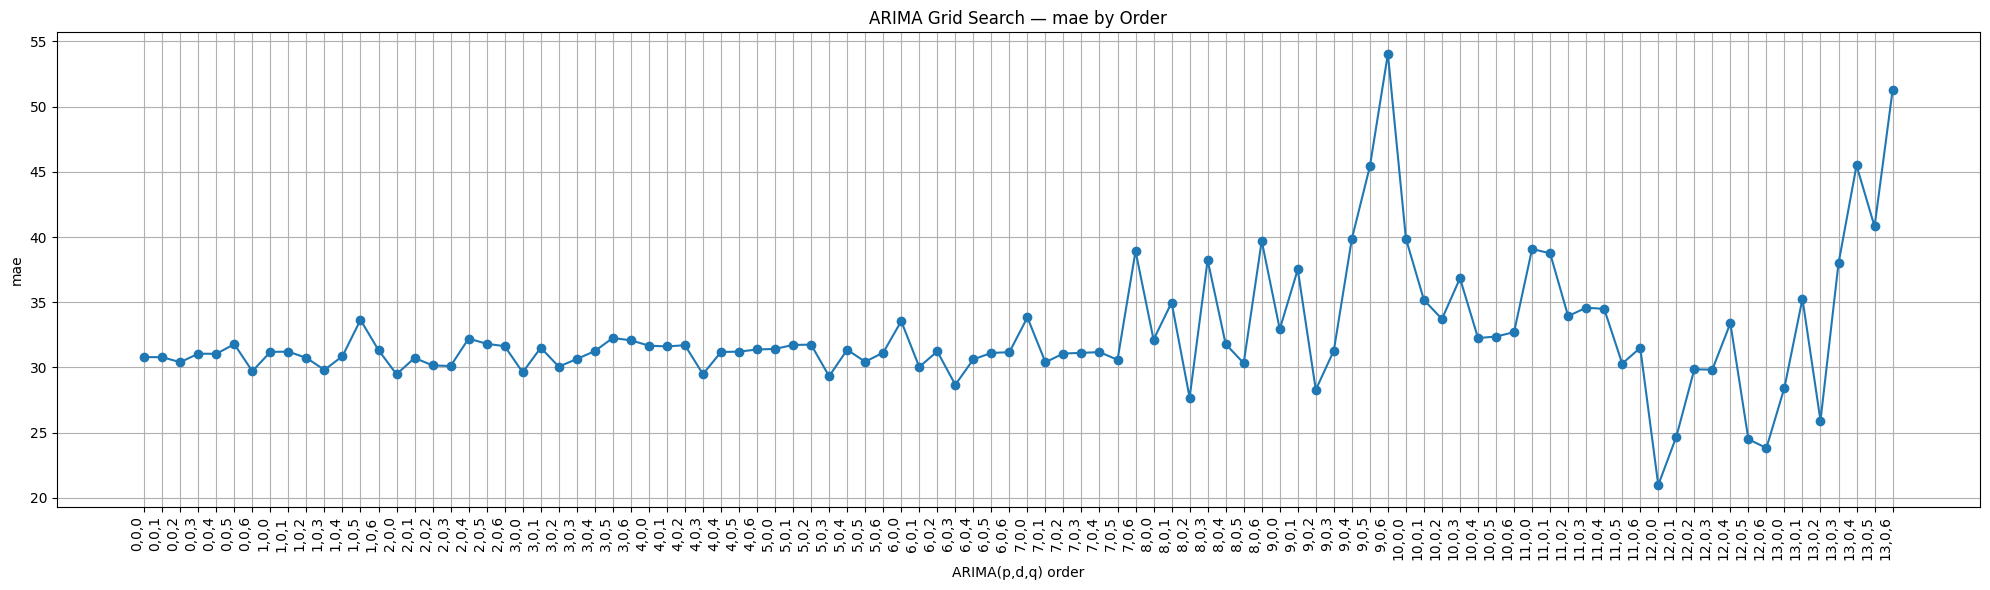

Best ARIMA order: (12, 0, 0) → mae = 20.98
Rolling-Window Forecast Evaluation:
MAE:  20.979
RMSE: 719.620
MAPE: 1.12%
R2:   0.4133


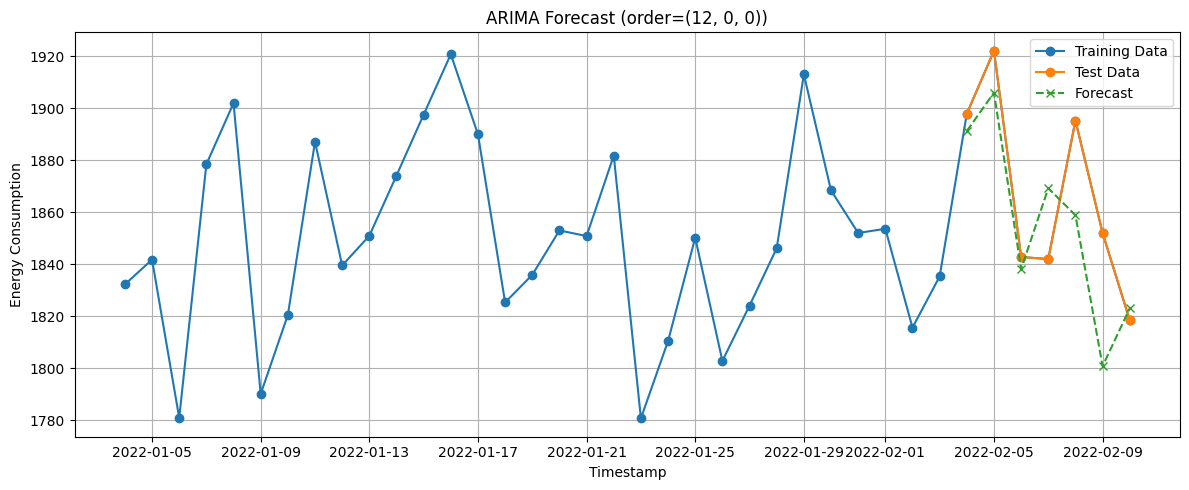

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily
mae,6.704103,29.422096,6.745177,20.979117
rmse,68.050988,1391.544903,66.351638,719.619933
mape,8.750275,1.557443,9.008152,1.122592
r2,-0.012465,-0.134533,0.012818,0.413290


In [ ]:
# import test
train_day = df_daily.iloc[:-forecast_horizon][target_col].asfreq('D')
test_day = df_daily.iloc[-forecast_horizon:][target_col].asfreq('D')

best_order_daily, best_mape_daily, results_daily = grid_search_arima(
    train_day,
    test_day,
    p_range=range(0,14),
    d_range=[0],
    q_range=range(0,7),
    metric= 'mae'
)

df_predictions_daily = arima_model(train_day, test_day, best_order_daily)
# Evaluate and visualize
result_arima_daily = evaluate_model(df_predictions_daily, verbose=True)
title = f"ARIMA Forecast (order={best_order_daily})"
visualize_prediction(df_predictions_daily, df_daily, title, last_n_samples=64)
df_model_results['ARIMA_Daily'] = result_arima_daily
df_model_results
